In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import numpy as np
import gym as gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import time
import cv2 as cv2
import random
import tensorflow.contrib.eager as tfe
import tensorflow as tf
tf.enable_eager_execution()
%matplotlib inline

from utils.plotting import RewardHistory


/home/william/anaconda3/envs/dev/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Policy Gradient with a model

In [36]:
# import tensorflow.contrib.eager as tfe

class LinearModel(tf.keras.Model):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=2, activation=tf.nn.softmax)

    def call(self, input):
        result = self.dense1(input)
        return result
    
    
    def loss(self, inputs, targets):
        y = self(inputs)
        loss = y * tf.cast(targets, dtype="float32")
        loss = tf.reduce_sum(loss, reduction_indices=1)
#         print(loss.shape)
        loss = tf.log(loss)
        return loss

    def grad(self, inputs, targets, reward):
        with tfe.GradientTape() as tape:
            loss_value = - tf.reduce_mean(self.loss(inputs, targets) * reward)
        return tape.gradient(loss_value, self.variables)
    
    def train(self, optimizer, inputs, targets, reward):
        grads = self.grad(inputs, targets, reward)
        optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())
    
model = LinearModel()

batch = tf.random_uniform([3, 4])
print("batch:", batch)

reward = tf.constant([5., 5., 5.])
reward = tf.expand_dims(reward, axis=1)
print("reward:", reward)

result = model(batch)
print("result:", result)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

num_epochs = 5

for epoch in range(num_epochs):

#     y = tf.constant([[0], [1]], dtype="int32")
    y = tf.one_hot([0, 1, 1], depth=2, dtype="int32")
#     y = tf.constant([1, 0, 1], dtype="int32")

    # Optimize the model
    grads = model.grad(batch, y, reward)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())
        
model(batch)

batch: tf.Tensor(
[[0.81653655 0.7700957  0.29644847 0.13605809]
 [0.04950047 0.11021364 0.82901967 0.16017461]
 [0.73726773 0.67315614 0.7928866  0.51046145]], shape=(3, 4), dtype=float32)
reward: tf.Tensor(
[[5.]
 [5.]
 [5.]], shape=(3, 1), dtype=float32)
result: tf.Tensor(
[[0.5511133  0.4488867 ]
 [0.67887825 0.32112178]
 [0.66132474 0.33867526]], shape=(3, 2), dtype=float32)


<tf.Tensor: id=253573, shape=(3, 2), dtype=float32, numpy=
array([[0.47731766, 0.52268237],
       [0.6306618 , 0.36933824],
       [0.5752905 , 0.42470953]], dtype=float32)>

In [130]:
# import tensorflow.contrib.eager as tfe

class ValueModel(tf.keras.Model):
    def __init__(self):
        super(ValueModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=1)

    def call(self, inputs):
        result = self.dense1(inputs)
        result = self.dense2(result)
#         result = self.dense2(inputs)
        return result
    
    
    def loss(self, inputs, targets):
        y = self(inputs)
        loss = tf.losses.mean_squared_error(targets, y)
#         loss = tf.squared_difference(targets, y)
        return loss

    def grad(self, inputs, targets):
        with tfe.GradientTape() as tape:
            loss_value = self.loss(inputs, targets)
        return tape.gradient(loss_value, self.variables)
    
    def train(self, optimizer, inputs, targets):
        grads = self.grad(inputs, targets)
        optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())
    

model = ValueModel()

batch = tf.random_uniform([3, 4])
print("batch:", batch)

result = model(batch)
print("result:", result)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

num_epochs = 5

for epoch in range(num_epochs):

    y = tf.expand_dims(tf.constant([5, 5, 5], dtype=tf.float32), axis=1)

    # Optimize the model
    model.train(optimizer, batch, y)
    
        
model(batch)

batch: tf.Tensor(
[[0.7472546  0.3253466  0.9667711  0.3406458 ]
 [0.67316973 0.8405758  0.04402089 0.7717488 ]
 [0.7702409  0.20590174 0.4290744  0.4862194 ]], shape=(3, 4), dtype=float32)
result: tf.Tensor(
[[0.07741328]
 [0.201864  ]
 [0.01075613]], shape=(3, 1), dtype=float32)


<tf.Tensor: id=231637890, shape=(3, 1), dtype=float32, numpy=
array([[1.8894635],
       [1.9028518],
       [1.5215579]], dtype=float32)>

# Ok, now we do Policy Gradient in actor critic: 1 sample at a time

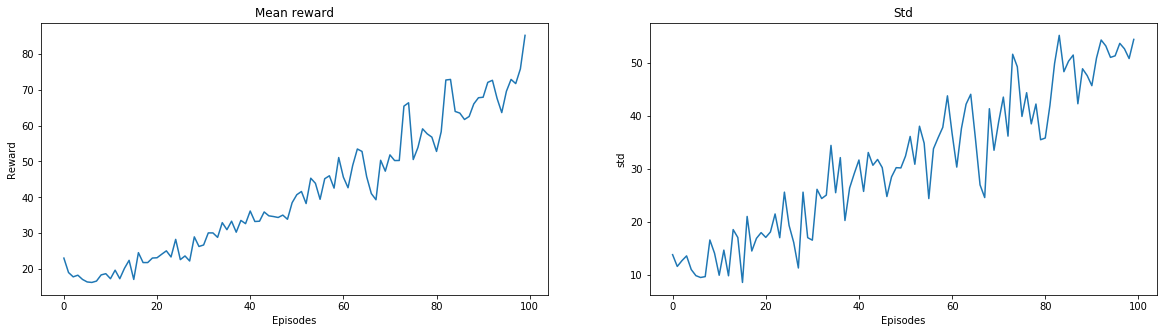

In [127]:
class Agent():
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.episode_durations = []
        self.episode_loss = []
        self.gamma = 0.99
        self.model = LinearModel()
        self.value_model = ValueModel()
#         self.memory = PolicyGradientMemory()
        self.action_optimizer = tf.train.AdamOptimizer(learning_rate=0.02)
        self.value_optimizer = tf.train.AdamOptimizer(learning_rate=0.02)
        
    def getAction(self, s):
        s = tf.convert_to_tensor([s])
        action_probability = self.model(s).numpy()
#         print(action_probability)
        action = np.random.choice([0, 1], p=action_probability[0])
        return action
    
    def train(self, episodes=2):
        all_returns = [[] for _ in range(200)]
        for i in range(episodes):
            s = self.env.reset()
            steps = 0
            while True:
                action = self.getAction(s)
                
                s_1, reward, done, info = self.env.step(action)
#                 self.memory.append(Transition(s, action, reward))
                
                s0 = tf.constant([s])
                s1 = tf.constant([s_1])
                r = tf.constant([reward])
                a = tf.one_hot([action], depth=2, dtype="int32")
                d = tf.constant([1 - done], dtype=tf.float32)
                
                v = self.value_model(s0)
                v_prime = self.value_model(s1)
                y = r + self.gamma * d * v_prime
#                 print(y.numpy(), v.numpy())
                td_loss = y - v
                
                self.value_model.train(self.value_optimizer, s0, y)
                self.model.train(self.action_optimizer, s0, a, td_loss)
    
                s = s_1
                
                steps += 1
                if done:
                    break

            self.episode_durations.append(steps)
    
    def run(self):
        self.env = gym.make('CartPole-v0')
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.getAction(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            steps += 1
            if done:
                print("Episode finished successfully after {} timesteps".format(steps))
                break
        self.env.close()

agent = Agent()

reward_history = RewardHistory()
for i in range(50):
    agent = Agent()
    agent.train(100)
    reward_history.append(agent.episode_durations)
reward_history.plot()

In [ ]:
###### learner.train(100, show_chart)
for i in range(2):
    agent.run()


# Lessons Learnt


- This is sensitive to the learning rate of both actor and critic

# Mean reward over 100 training sessions

- Actor Critic, learning from 1 sample at a time. Cannot reproduce this anymore lol
![mean reward](./images/actor_critic.png)

# Batch learning

In [128]:
Transition = namedtuple("Transition", ["s", "a", "s1", "r", "done"])

class PolicyGradientMemory():
    def __init__(self, gamma = 0.9):
        self.memory = []
        self.gamma = gamma
    
    def reset(self):
        self.memory = []
    
    def append(self, transition):
        self.memory.append(transition)
        
    
    def sample(self):
        batched = Transition(*zip(*self.memory))
        s = np.array(list(batched.s))
        a = np.array(list(batched.a))
        s1 = np.array(list(batched.s1))
        r = np.array(list(batched.r), dtype="float32")
        done = np.array(list(batched.done))
        
#         reward = 0.
#         for i in reversed(range(len(r))):
#             moving_reward = self.gamma * reward
#             reward = r[i] + moving_reward
#             r[i] = reward
#             print(i, len(r)-i-1, r[i])
#         r = np.expand_dims(r, axis=1)
        return [s, a, s1, r, done]
    
    def __len__(self):
        return len(self.memory)
    
    def __str__(self):
        result = []
        for i in range(self.__len__()):
            result.append(self.memory[i].__str__() + " \n")
        return "".join(result)

memory = PolicyGradientMemory()

memory.append(Transition([1, 2, 3], 1, [4, 5, 6], 1, True))
memory.append(Transition([1, 2, 3], 0, [4, 5, 6], 1, False))
memory.append(Transition([1, 2, 3], 0, [4, 5, 6], 1, False))
memory.append(Transition([1, 2, 3], 1, [4, 5, 6], 1, False))
memory.append(Transition([1, 2, 3], 1, [4, 5, 6], 1, False))


# print(memory)
a = memory.sample()
print("s:", a[0])
print("a:", a[1])
print("s1:", a[2])
print("r:", a[3])
print("done:", a[4])




s: [[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]
a: [1 0 0 1 1]
s1: [[4 5 6]
 [4 5 6]
 [4 5 6]
 [4 5 6]
 [4 5 6]]
r: [1. 1. 1. 1. 1.]
done: [ True False False False False]


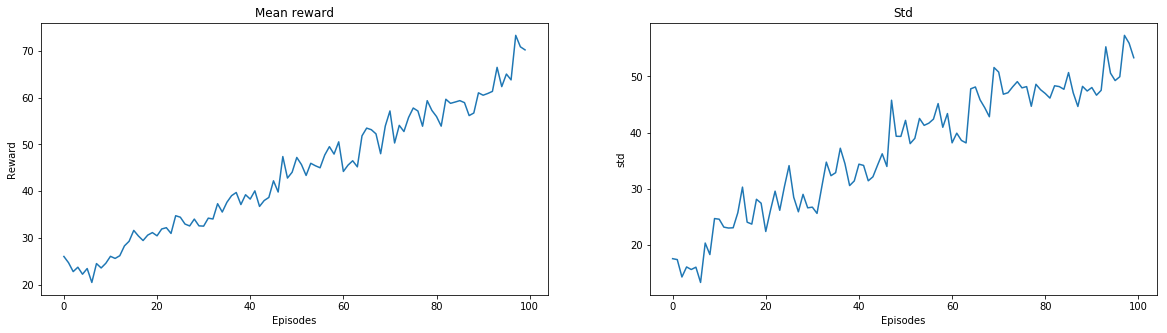

In [138]:
class Agent():
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        self.episode_durations = []
        self.episode_loss = []
        self.gamma = 0.99
        self.model = LinearModel()
        self.value_model = ValueModel()
        self.memory = PolicyGradientMemory()
        self.action_optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
        self.value_optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
        
    def getAction(self, s):
        s = tf.convert_to_tensor([s])
        action_probability = self.model(s).numpy()
#         print(action_probability)
        action = np.random.choice([0, 1], p=action_probability[0])
        return action
    
    def train(self, episodes=2):
        all_returns = [[] for _ in range(200)]
        for i in range(episodes):
            s = self.env.reset()
            steps = 0
            while True:
                action = self.getAction(s)
                
                s_1, reward, done, info = self.env.step(action)
                self.memory.append(Transition(s, action, s_1, reward, done))
                
                s = s_1
                
                steps += 1
                if done:
                    break

            s0, a, s1, r, done = self.memory.sample()
            s0 = tf.constant(s0, dtype=tf.float32)
            a = tf.one_hot(a, depth=2, dtype=tf.int32)
            s1 = tf.constant(s1, dtype=tf.float32)
            r = tf.expand_dims(tf.constant(r, dtype=tf.float32), axis=1)
            d = tf.expand_dims(tf.constant(1 - done, dtype=tf.float32), axis=1)
            
            v = self.value_model(s0)
            v_prime = self.value_model(s1)
            y = r + self.gamma * d * v_prime
#             print(y)
            td_loss = y - v
#                 print(tf.reduce_max(td_loss).numpy())

            self.value_model.train(self.value_optimizer, s0, y)
            self.model.train(self.action_optimizer, s0, a, td_loss)
            self.memory.reset()
            
            self.episode_durations.append(steps)
    
    def run(self):
        self.env = gym.make('CartPole-v0')
        s = self.env.reset()
        steps = 0
        while True:
            self.env.render()
            action = self.getAction(s)
            s_1, reward, done, info = self.env.step(action)
            s = s_1
            steps += 1
            if done:
                print("Episode finished successfully after {} timesteps".format(steps))
                break
        self.env.close()

agent = Agent()

reward_history = RewardHistory()
for i in range(100):
    agent = Agent()
    agent.train(100)
    reward_history.append(agent.episode_durations)

reward_history.plot()

# Mean return over 100 runs
- Actor Critic batched
![mean reward](./images/actor_critic_batch.png)

In [65]:
agent.run()

Episode finished successfully after 200 timesteps


# Combined model

In [ ]:
# import tensorflow.contrib.eager as tfe

class CombinedModel(tf.keras.Model):
    def __init__(self):
        super(ValueModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=1)

    def call(self, input):
        result = self.dense1(input)
        result = self.dense2(result)
        return result
    
    
    def v_loss(self, inputs, targets):
        y = self(inputs)
        loss = tf.losses.mean_squared_error(targets, y)
        return loss

    def v_grad(self, inputs, targets):
        with tfe.GradientTape() as tape:
            loss_value = tf.reduce_mean(self.loss(inputs, targets))
        return tape.gradient(loss_value, self.variables)
    
    def v_train(self, optimizer, inputs, targets):
        grads = self.grad(inputs, targets)
        optimizer.apply_gradients(zip(grads, self.variables),
                          global_step=tf.train.get_or_create_global_step())
    

model = ValueModel()

batch = tf.random_uniform([3, 4])
print("batch:", batch)

result = model(batch)
print("result:", result)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01)

num_epochs = 5

for epoch in range(num_epochs):

    y = tf.expand_dims(tf.constant([5, 5, 5], dtype="int32"), axis=1)

    # Optimize the model
    model.train(optimizer, batch, y)
    
        
model(batch)